# Testing Machine Learning Techniques on the Sandbox Data

There are a couple of places where that strategy can be improved upon:

- The bins are discrete and not continuous.  Machine learning allows us to treat continuous parameters as continuous.
- The channel usage was uneven across the offers, and has a large impact on the results.  While the test does make clear that _particular combinations_ of channel usage and offer structure do worse than others, the test cannot tell us how that offer structure would have performed with broader channel usage.

## Plan: Use the data to go beyond the specific combinations used in the test

In [1]:
import pandas as pd
import numpy as np
import math
import json
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
sns.set_context('talk')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf

%matplotlib inline

palette = sns.color_palette()

In [10]:
# load dataframes from main notebook
offers_rev = pd.read_pickle('offers_rev.pkl')
profile_extended = pd.read_pickle('profile_extended.pkl')
portfolio_extended = pd.read_pickle('portfolio_extended.pkl')

In [6]:
profile_extended.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income',
       'days_of_membership', 'anonymous', 'median_transaction',
       'max_transaction', 'max_med_trans_ratio', 'max_transaction_binned',
       'median_transaction_binned', 'max_transaction_no_outliers',
       'max_trans_no_out_binned', 'median_transaction_no_outliers',
       'median_trans_no_out_binned', 'has_outlier', 'n_transactions',
       'total_amount', 'n_offers', 'n_offers_viewed', 'n_offers_completed',
       'n_offers_completed_not_viewed', 'frac_viewed', 'frac_completed',
       'frac_completed_unviewed', 'income_binned', 'age_binned',
       'membership_days_binned'],
      dtype='object')

In [11]:
# bring in median transaction amount from profiles
offers_rev = pd.merge(offers_rev,
         profile_extended[['id', 'median_transaction_no_outliers']],
         left_on='person', right_on='id', how='left').drop(columns='id')
offers_rev['median_transaction_no_outliers'] = offers_rev['median_transaction_no_outliers'].fillna(0)

In [12]:
# Define users "influenced" by an offer as users who:
# (a) Viewed an offer and (b) Did not complete it before viewing it
offers_rev['influenced'] = ((offers_rev[offers_rev.offer_id != 'no_offer'].viewed) & ~(
                            offers_rev[offers_rev.offer_id != 'no_offer'].time_completed <
                            offers_rev[offers_rev.offer_id != 'no_offer'].time_viewed))

In [15]:
# use a subset of the data for machine learning
offers_rev_subset = offers_rev[(offers_rev.offer_id != 'no_offer') & (offers_rev.time_received < 500)].loc[:,
    ['gender', 'age', 'days_of_membership', 'income', 'anonymous',
     'influenced', 'completed', 'ten_day_profit', 'offer_id',
     'person', 'median_transaction_no_outliers']]
offers_rev_subset.head()

,gender,age,days_of_membership,income,anonymous,influenced,completed,ten_day_profit,offer_id,person,median_transaction_no_outliers
3,F,75,443,100000.0,False,True,True,21.7650,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,21.72
4,None,118,356,NaN,True,True,False,0.2725,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,1.09
5,M,68,91,70000.0,False,True,False,0.0000,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,18.42
6,None,118,304,NaN,True,True,False,0.0000,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0.00
7,None,118,297,NaN,True,True,False,0.0000,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0.12


In [18]:
def train_test_split(df, train_frac):
    """
    Splits the dataframe into training, validation and testing sets
    
    INPUT:
    df: (dataframe) - a pandas dataframe to be split
    train_frac: (float) - fraction of the dataset for training
    
    RETURNS:
    (train_df, test_df) - tuple of pandas dataframes
    """

    shuffled = df.sample(frac=1)
    train_end_index = round(df.shape[0] * train_frac)
    
    train_df = shuffled.iloc[0:train_end_index, :]
    test_df = shuffled.iloc[train_end_index:,:]
    
    return (train_df, test_df)

In [19]:
# split test dataset off at the beginning
# training data and validation data will be subsetted from the training data
# testing data will be subsetted from the testing data

train_df, test_df = train_test_split(offers_rev_subset, 0.8)

In [20]:
# fit scalers to the training data
scalers = {'days_of_membership': None, 'age': None, 'income': None, 'median_transaction_no_outliers': None}

for column in scalers.keys():
    scalers[column] = StandardScaler().fit(train_df[column].values.reshape(-1,1))

In [39]:
def prepare_tensorflow_dataset(df, scalers, categorical_variables, target, feature_names=None):
    """
    A pipeline for preparing the offers dataframes for tensorflow.
    
    INPUT:
    df: (dataframe) - a dataframe with continuous variables to be scaled
    scalers: (dict) containing sklearn scaler objects, keys are column names
                    implicitly sets the list of continuous variables
    categorical_variables: (list): column names to pass to pd.get_dummies
    target: (str): the column containing the target values
    feature_names: (list) feature names will be appended to this list.  not returned.
    
    RETURNS:
    dataset: (tf.data.Dataset): a tensorflow dataset
    """
    
    # copy the dataframe in function scope and limit to relevant columns
    cols = list(scalers.keys()) + categorical_variables + [target]
    local_df = df[cols].copy()
    # scale the continuous variables
    for column in scalers.keys():
        local_df[column] = scalers[column].transform(local_df[column].values.reshape(-1,1))
        
    dummied = pd.get_dummies(local_df, columns=categorical_variables, drop_first=True)
    
    if feature_names is not None:
        feature_names += dummied.columns[dummied.columns != target].tolist()
    
    X = dummied.loc[:,dummied.columns != target].values
    
    # tensorflow cannot accept boolean values so
    #   - if dtype is float, pass as is
    #   - else, convert to int
    if dummied.dtypes[target] == 'float64':
        y = dummied[target].values.reshape(-1,1)
    else:
        y = dummied[target].values.reshape(-1,1).astype(int)
        
        
    return tf.data.Dataset.from_tensor_slices((X, y))

# Estimate P(Complete|Influence) and P(Complete|~Influence)

Estimate the likelihood that a given user will complete an offer, given that they viewed it before completing it.

In [108]:
feature_names_Pcompl = []
# prepare training and validation sets from train data
df_P_compl = train_df[~train_df.anonymous]
splits_p_compl = train_test_split(df_P_compl, 0.8)
train_compl, valid_compl = [prepare_tensorflow_dataset(data,
                                                     scalers,
                                                     ['gender', 'influenced'],
                                                     'completed').batch(32) for data in splits_p_compl]

# prepare test data from test data
test_P_compl = test_df[~test_df.anonymous]
test_compl = prepare_tensorflow_dataset(test_P_compl,
                                      scalers,
                                      ['gender','influenced'],
                                      'completed', feature_names_Pcompl).batch(32)

In [109]:
#Add model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='complete_best.h5', 
                                                               monitor='val_loss', save_best_only=True,
                                                              save_freq='epoch', mode='auto')

# Model Architecture
model_P_Complete = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'),
                                        tf.keras.layers.Dense(16, activation='relu'),
                                        tf.keras.layers.Dense(1)])

# Compile Model
model_P_Complete.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          metrics=['accuracy'])

# Fit model
model_P_Complete.fit(train_compl, epochs=7, validation_data=train_compl,
                     callbacks=[early_stop, model_checkpoint]);

# Load best model from training
model_P_Complete.load_weights('complete_best.h5')

Epoch 1/7
886/886 [==============================] - 2s 2ms/step - loss: 0.6266 - accuracy: 0.5999 - val_loss: 0.5766 - val_accuracy: 0.6733
Epoch 2/7
886/886 [==============================] - 1s 1ms/step - loss: 0.5721 - accuracy: 0.6721 - val_loss: 0.5702 - val_accuracy: 0.6874
Epoch 3/7
886/886 [==============================] - 1s 1ms/step - loss: 0.5683 - accuracy: 0.6823 - val_loss: 0.5682 - val_accuracy: 0.6891
Epoch 4/7
886/886 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.6849 - val_loss: 0.5671 - val_accuracy: 0.6913
Epoch 5/7
886/886 [==============================] - 1s 1ms/step - loss: 0.5662 - accuracy: 0.6875 - val_loss: 0.5664 - val_accuracy: 0.6929
Epoch 6/7
886/886 [==============================] - 1s 1ms/step - loss: 0.5657 - accuracy: 0.6889 - val_loss: 0.5657 - val_accuracy: 0.6935
Epoch 7/7
886/886 [==============================] - 1s 1ms/step - loss: 0.5652 - accuracy: 0.6904 - val_loss: 0.5652 - val_accuracy: 0.6938


In [44]:
# tf.data.Dataset is an iterable, need to get a full list of predictions and labels from the test data
# define function to help

def predict_test_data(model, test_batches, feature_names, scalers = {}, activation=tf.math.sigmoid):
    """
    A function to return a pandas dataframe of predicted vs actual labels given a model and testing dataset.
    
    INPUT:
    model (tf.keras.model): the trained model
    test_batches (tf.data.Dataset): a batched dataset containing the testing data
    feature_names (list): an ordered list of the feature names matching the features in test_batches
    scalers(optional): (dict) a dictionary of scaler objects to reverse-transform the features
    activation(optional): (function) activation function to be applied to the prediction results
    
    Returns:
    df (pd.DataFrame): a pandas dataframe containing predicted and actual values with features
    """
    
    labels = []
    predictions = []
    features = []
    for batch_features, batch_labels in test_batches:
        preds = model.predict(batch_features).reshape(-1)
        if activation is not None:
            preds = activation(preds)
        predictions.append(preds)
        labels.append(batch_labels)
        features.append(batch_features)
        
    df_results = pd.DataFrame(data={'labels': np.concatenate(labels).reshape(-1),
                  'predictions': np.concatenate(predictions)})
    
    df_features = pd.DataFrame(data=np.concatenate(features), columns=feature_names)
    
    for column in scalers.keys():
        df_features[column] = scalers[column].inverse_transform(df_features[column])
    
    return pd.concat([df_features, df_results], axis=1)

In [114]:
# predict on test data
test_compl_result = predict_test_data(model_P_Complete, test_compl, feature_names_Pcompl, scalers)
print("Model PComplete Accuracy on Test Data:", model_P_Complete.evaluate(test_compl)[1])

278/278 [==============================] - 0s 675us/step - loss: 0.5740 - accuracy: 0.6789
Model PComplete Accuracy on Test Data: 0.6788732409477234


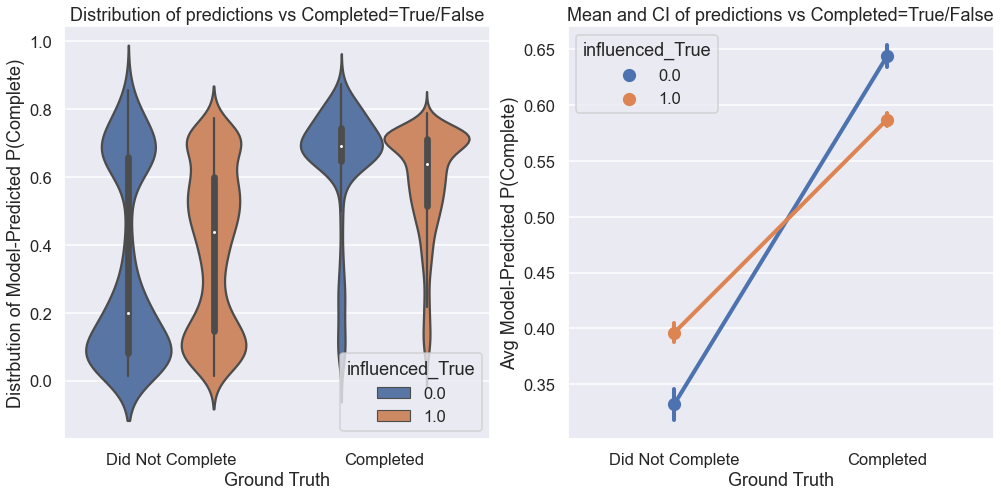

In [124]:
# plot results
f, axs = plt.subplots(ncols=2, figsize=(14,7))
axs = axs.flatten()
sns.violinplot(data=test_compl_result, x='labels', y='predictions', hue='influenced_True', ax=axs[0])
sns.pointplot(data=test_compl_result, x='labels', y='predictions', hue='influenced_True', ax=axs[1])
axs[0].set(title='Distribution of predictions vs Completed=True/False', xlabel='Ground Truth',
           xticklabels=['Did Not Complete', 'Completed'],
          ylabel='Distrbution of Model-Predicted P(Complete)')
axs[1].set(title='Mean and CI of predictions vs Completed=True/False', xlabel='Ground Truth',
           xticklabels=['Did Not Complete', 'Completed'],
          ylabel='Avg Model-Predicted P(Complete)')
plt.tight_layout();

In [116]:
print("Average P(Complete) (training data):", df_P_compl.completed.mean())
print("Average P(Complete|Influence) (training data):", df_P_compl[df_P_compl.influenced].completed.mean())
print("Average P(Complete|~Influence) (training data):", df_P_compl[
                                            ~(df_P_compl.influenced.astype(bool))].completed.mean())

Average P(Complete) (training data): 0.48380538220427527
Average P(Complete|Influence) (training data): 0.49222065063649223
Average P(Complete|~Influence) (training data): 0.4642857142857143


# Results: P(Complete|Influence) & P(Complete|~Influence) (users with profile)

There is significant separation between predictions based on the true labels, bracketing the naive probability prediction of the average from the training data.  This model will add to our ability to pick the best offer for customers.

# Estimate 10-Day Profit

Model needs to estimate the 10-day profit that each offer would bring in (rewards to be handled separately by models predicting P(Complete|Influence) and P(Complete|~Influence).

In [40]:
feature_names_rev = []
# prepare training and validation sets from train data
df_rev = train_df[~train_df.anonymous & train_df.influenced]
splits_rev = train_test_split(df_rev, 0.8)
train_rev, valid_rev = [prepare_tensorflow_dataset(data,
                                                     scalers,
                                                     ['gender', 'offer_id'],
                                                     'ten_day_profit', []).batch(32)
                        for data in splits_rev]

# prepare test data from test data
test_revenue = test_df[~test_df.anonymous & test_df.influenced]
test_rev = prepare_tensorflow_dataset(test_revenue,
                                      scalers,
                                      ['gender','offer_id'],
                                      'ten_day_profit', feature_names_rev).batch(32)

In [43]:
#Add Early Stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)

#Add model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='revenue_best.h5', 
                                                               monitor='val_loss', save_best_only=True,
                                                              save_freq='epoch', mode='auto')

# Model Architecture
model_rev = tf.keras.Sequential([tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dense(32, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                        tf.keras.layers.Dense(1)])

# Compile Model
model_rev.compile(optimizer='adam', loss='MSE')

# Fit model
model_rev.fit(train_rev, epochs=15, validation_data=valid_rev,
                     callbacks=[early_stop, model_checkpoint]);

# Load best model from training
model_rev.load_weights('revenue_best.h5')

Epoch 1/15
619/619 [==============================] - 1s 904us/step - loss: 109.1305 - val_loss: 60.8429
Epoch 2/15
619/619 [==============================] - 1s 807us/step - loss: 62.4744 - val_loss: 58.4506
Epoch 3/15
619/619 [==============================] - 0s 794us/step - loss: 60.6436 - val_loss: 57.9045
Epoch 4/15
619/619 [==============================] - 0s 801us/step - loss: 59.9641 - val_loss: 57.6276
Epoch 5/15
619/619 [==============================] - 1s 808us/step - loss: 59.5205 - val_loss: 57.4157
Epoch 6/15
619/619 [==============================] - 1s 810us/step - loss: 59.1807 - val_loss: 57.2475
Epoch 7/15
619/619 [==============================] - 1s 813us/step - loss: 58.9139 - val_loss: 57.1265
Epoch 8/15
619/619 [==============================] - 0s 803us/step - loss: 58.6755 - val_loss: 56.9774
Epoch 9/15
619/619 [==============================] - 1s 822us/step - loss: 58.4221 - val_loss: 56.8279
Epoch 10/15
619/619 [==============================] - 0s 803us

In [105]:
test_rev_result = predict_test_data(model_rev, test_rev,
                                        feature_names_rev,
                                     scalers, activation=None)

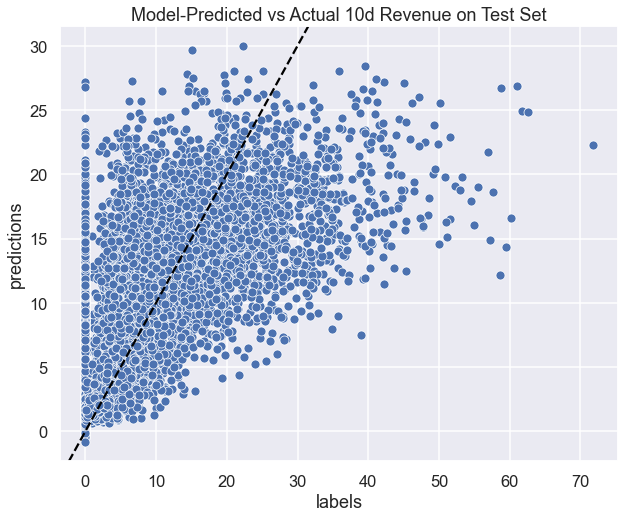

In [75]:
# this performance doesn't look very good
# but do have to keep in mind what our competition is

f, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=test_rev_result, x='labels', y='predictions', ax=ax)
ax.axline([0, 0], [1, 1], color='black', ls='--')
ax.set(title='Model-Predicted vs Actual 10d Revenue on Test Set');

In [70]:
# evaluate MSE on test set
print("MSE of Model on Test Set:", model_rev.evaluate(test_rev))

194/194 [==============================] - 0s 669us/step - loss: 61.2683
MSE of Model on Test Set: 61.268333435058594


In [76]:
# evaluate MSE for just guessing the average for each offer
# so the model is doing much better than just guessing the average
avg_profit_by_offer = offers_rev.groupby(by='offer_id')['ten_day_profit'].mean().rename('ten_day_profit_avg')

test_revenue_guess = pd.merge(test_revenue,
                              avg_profit_by_offer,
                              left_on='offer_id', right_index=True, how='left')

print("MSE of Using Overall Average for Each Offer:", 
tf.keras.metrics.mean_squared_error(test_revenue_guess.ten_day_profit,
                                    test_revenue_guess.ten_day_profit_avg).numpy())

MSE of Using Overall Average for Each Offer: 107.20179642090032


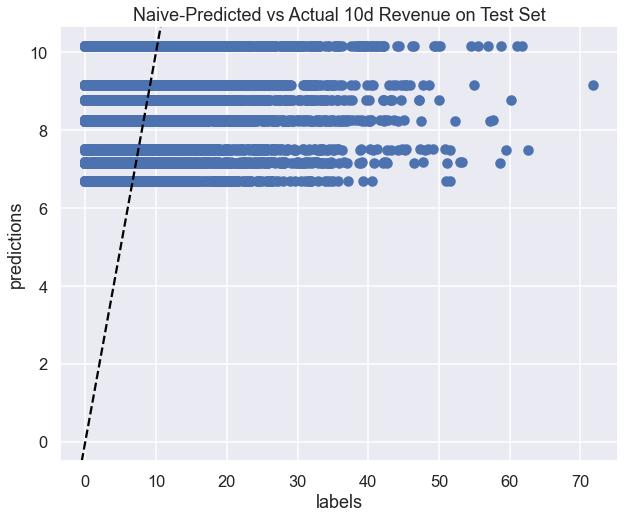

In [74]:
# plot predicted/actual for naive prediction
f, ax = plt.subplots(figsize=(10,8))
ax.scatter(test_revenue_guess.ten_day_profit, test_revenue_guess.ten_day_profit_avg)
ax.axline([0, 0], [1, 1], color='black', ls='--')
ax.set(xlabel='labels', ylabel='predictions', title='Naive-Predicted vs Actual 10d Revenue on Test Set');

In [106]:
# ok so is the model doing better or worse on certain offers?

# bring predictions back into normal dataframe (not one-hot encoded)
test_rev_result = pd.concat([test_revenue.reset_index(), test_rev_result.reset_index()['predictions']], axis=1)
test_rev_result['predicted-actual'] = test_rev_result.predictions - test_rev_result.ten_day_profit
test_rev_result = pd.merge(test_rev_result, portfolio_extended[['id', 'nickname', 'offer_type']],
                           left_on='offer_id', right_on='id', how='left')

<AxesSubplot:xlabel='predicted-actual', ylabel='nickname'>

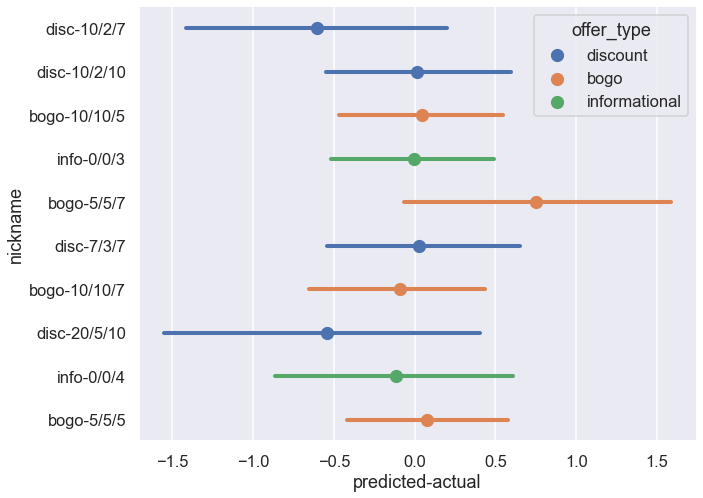

In [107]:
# plot predicted - actual for different offers to see if the model over/underpredicts for some
f, ax = plt.subplots(figsize=(10,8))
sns.pointplot(data=test_rev_result, x='predicted-actual', y='nickname', hue='offer_type', ax=ax, join=False);

## Model Performance

So the model does do significantly better at predicting ten day profit than naively taking the average for any given offer.

Unfortunately, the model is biased in how it predicts: it overpredicts for the bogo-5/5/7 offer and underpredicts for the disc-10/2/7 and disc-20/5/10 offers.  This makes it hard to use for selecting the best offer since it will always favor or disfavor certain offers.

One way to get around this would be to train a separate model for each offer, but time pressure for the project submission did not allow for that.